In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from re import search

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

In [237]:
raw_data = pd.read_csv('../data/listings.csv')

In [238]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10109 non-null  int64  
 1   listing_url                                   10109 non-null  object 
 2   scrape_id                                     10109 non-null  int64  
 3   last_scraped                                  10109 non-null  object 
 4   name                                          10109 non-null  object 
 5   description                                   9910 non-null   object 
 6   neighborhood_overview                         6480 non-null   object 
 7   picture_url                                   10108 non-null  object 
 8   host_id                                       10109 non-null  int64  
 9   host_url                                      10109 non-null 

In [240]:
to_drop_columns = ['id',
                   'listing_url',
                   'scrape_id',
                   'last_scraped',
                   'name',
                   'description',
                   'neighborhood_overview',
                   'picture_url',
                   'host_id',
                   'host_url',
                   'host_name',
                   'host_since',
                   'host_location',
                   'host_about',
                   'host_response_time',
                   'host_response_rate',
                   'host_acceptance_rate',
                   'host_thumbnail_url',
                   'host_picture_url',
                   'host_neighbourhood',
                   'host_listings_count',
                   'host_total_listings_count',
                   'host_verifications',
                   'host_has_profile_pic',
                   'neighbourhood',
                   'neighbourhood_group_cleansed',
                   'bathrooms',
                   'minimum_minimum_nights',
                   'maximum_minimum_nights',
                   'minimum_maximum_nights',
                   'maximum_maximum_nights',
                   'minimum_nights_avg_ntm',
                   'maximum_nights_avg_ntm',
                   'calendar_updated',
                   'calendar_last_scraped'
                   'license',
                  ]

In [241]:
to_try = ['latitude',
          'longitude',
          'property_type',
          'has_availability',
          'availability_30',
          'availability_60',
          'number_of_reviews_ltm',
          'first_review',
          'last_review',
          'calculated_host_listings_count_entire_homes',
          'calculated_host_listings_count_private_rooms',
          'calculated_host_listings_count_shared_rooms'
         ]

In [242]:
to_keep = ['host_is_superhost',
           'host_identity_verified',
           'neighbourhood_cleansed',
           'room_type',
           'accommodates',
           'bathrooms_text',
           'bedrooms',
           'beds',
           'amenities',
           'price',
           'minimum_nights',
           'maximum_nights',
           'availability_90',
           'availability_365',
           'number_of_reviews',
           'number_of_reviews_l30d',
           'review_scores_rating',
           'review_scores_accuracy',
           'review_scores_cleanliness',
           'review_scores_checkin',
           'review_scores_communication',
           'review_scores_location',
           'review_scores_value',
           'instant_bookable',
           'calculated_host_listings_count',
           'reviews_per_month'
          ]

In [244]:
raw_to_keep = raw_data.loc[:, to_keep]

In [245]:
raw_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               9814 non-null   object 
 1   host_identity_verified          9814 non-null   object 
 2   neighbourhood_cleansed          10109 non-null  int64  
 3   room_type                       10109 non-null  object 
 4   accommodates                    10109 non-null  int64  
 5   bathrooms_text                  10094 non-null  object 
 6   bedrooms                        9425 non-null   float64
 7   beds                            9886 non-null   float64
 8   amenities                       10109 non-null  object 
 9   price                           10109 non-null  object 
 10  minimum_nights                  10109 non-null  int64  
 11  maximum_nights                  10109 non-null  int64  
 12  availability_90                 

In [246]:
clean_to_keep = raw_to_keep.copy()

In [247]:
clean_to_keep['price'] = clean_to_keep['price'].apply(lambda x: x.replace('$', ''))
clean_to_keep['price'] = clean_to_keep['price'].apply(lambda x: x.replace(',', ''))
clean_to_keep['price'] = clean_to_keep['price'].astype('float64')

In [248]:
clean_to_keep['host_is_superhost'] = (clean_to_keep['host_is_superhost'] == 't')

In [249]:
clean_to_keep['host_identity_verified'] = (clean_to_keep['host_identity_verified'] == 't')

In [250]:
clean_to_keep['entire_home'] = (clean_to_keep['room_type'] == 'Entire home/apt')
clean_to_keep.drop(columns='room_type', inplace=True)

In [251]:
clean_to_keep['shared_bathroom'] = clean_to_keep['bathrooms_text'].str.contains('shared')
clean_to_keep['shared_bathroom'] = clean_to_keep['shared_bathroom'].astype('bool')

In [252]:
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.lower()
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('private ', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('shared ', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('half-bath', '0.5')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace(' bath', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('s', '')
clean_to_keep['bathrooms'] = clean_to_keep['bathrooms_text'].astype('float64')

In [544]:
clean_to_keep['bathrooms'].value_counts()

1.0     5881
2.0     2026
2.5      690
1.5      628
3.0      374
3.5      160
4.0      119
4.5       69
5.0       33
0.0       32
5.5       24
6.0       16
6.5       14
0.5       14
7.0        4
8.0        4
7.5        3
9.0        1
17.0       1
10.5       1
Name: bathrooms, dtype: int64

In [254]:
clean_to_keep['instant_bookable'] = (clean_to_keep['instant_bookable'] == 't')

In [255]:
clean_to_keep.drop(columns='bathrooms_text', inplace=True)

In [256]:
clean_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               10109 non-null  bool   
 1   host_identity_verified          10109 non-null  bool   
 2   neighbourhood_cleansed          10109 non-null  int64  
 3   accommodates                    10109 non-null  int64  
 4   bedrooms                        9425 non-null   float64
 5   beds                            9886 non-null   float64
 6   amenities                       10109 non-null  object 
 7   price                           10109 non-null  float64
 8   minimum_nights                  10109 non-null  int64  
 9   maximum_nights                  10109 non-null  int64  
 10  availability_90                 10109 non-null  int64  
 11  availability_365                10109 non-null  int64  
 12  number_of_reviews               

In [257]:
clean_to_keep.corr()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,entire_home,shared_bathroom,bathrooms
host_is_superhost,1.000000,0.116597,0.008777,0.031364,0.038240,0.041948,-0.065444,0.035279,-0.065490,0.052779,...,0.154995,0.160996,0.162142,0.242561,0.055286,0.134353,0.290250,0.113364,-0.052662,-0.006977
host_identity_verified,0.116597,1.000000,-0.018405,0.001204,-0.007321,-0.008157,-0.008562,0.026214,-0.000302,0.025992,...,-0.010497,-0.001803,0.007402,0.005000,0.052797,0.134589,0.024839,0.014440,0.014000,-0.013209
neighbourhood_cleansed,0.008777,-0.018405,1.000000,-0.067625,-0.027620,-0.039549,-0.069560,0.044551,-0.015904,-0.004474,...,-0.014493,-0.016492,-0.092207,0.030182,-0.033100,0.097279,-0.060300,-0.166656,0.143966,-0.008037
accommodates,0.031364,0.001204,-0.067625,1.000000,0.844689,0.738495,0.421576,-0.056903,0.051434,0.087668,...,0.016830,-0.019400,-0.002149,-0.061344,0.137327,0.003100,0.022475,0.409236,-0.273686,0.722016
bedrooms,0.038240,-0.007321,-0.027620,0.844689,1.000000,0.763515,0.462555,-0.020995,0.036026,0.045395,...,0.048651,0.006233,0.017511,-0.011177,0.045507,-0.037783,-0.037105,0.370443,-0.233346,0.830734
beds,0.041948,-0.008157,-0.039549,0.738495,0.763515,1.000000,0.390254,-0.029900,0.048640,0.074204,...,0.016376,-0.023350,0.003020,-0.046901,0.107615,0.013616,0.017033,0.253483,-0.164288,0.657632
price,-0.065444,-0.008562,-0.069560,0.421576,0.462555,0.390254,1.000000,-0.005078,0.003219,0.067956,...,0.015653,0.004912,0.015412,-0.048276,0.012165,-0.008311,-0.080124,0.153408,-0.123304,0.495174
minimum_nights,0.035279,0.026214,0.044551,-0.056903,-0.020995,-0.029900,-0.005078,1.000000,0.005498,0.043205,...,0.024381,0.013573,0.023489,0.006099,0.006762,0.214562,-0.093213,0.030031,0.000205,0.002997
maximum_nights,-0.065490,-0.000302,-0.015904,0.051434,0.036026,0.048640,0.003219,0.005498,1.000000,-0.007577,...,-0.026748,-0.025343,-0.021314,-0.062725,0.016220,0.007461,-0.012371,0.036524,-0.027322,0.027470
availability_90,0.052779,0.025992,-0.004474,0.087668,0.045395,0.074204,0.067956,0.043205,-0.007577,1.000000,...,-0.065694,-0.079992,-0.026909,-0.105478,0.106163,0.162491,0.237384,0.047511,-0.002600,0.040574


In [258]:
clean_to_keep['neighbourhood_cleansed'].value_counts()

78704    1798
78702    1236
78701     752
78741     625
78703     514
78745     492
78705     484
78751     455
78723     328
78758     262
78746     259
78734     217
78757     200
78721     199
78722     171
78744     166
78748     142
78756     130
78752     124
78729     116
78731     116
78754     114
78735     107
78749     102
78727     100
78737      98
78753      96
78759      87
78733      68
78724      62
78717      62
78728      56
78732      55
78736      50
78738      47
78747      45
78750      44
78725      41
78730      36
78739      27
78726      12
78742       7
78719       6
78712       1
Name: neighbourhood_cleansed, dtype: int64

In [259]:
clean_to_keep.describe()

,neighbourhood_cleansed,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,bathrooms
count,10109.000000,10109.000000,9425.000000,9886.000000,10109.000000,10109.00000,10109.000000,10109.000000,10109.000000,10109.000000,...,7596.000000,7518.000000,7518.000000,7517.000000,7517.000000,7512.000000,7513.000000,10109.000000,7707.000000,10094.000000
mean,78723.036898,4.570383,1.919363,2.479061,266.578297,7.99545,608.351568,26.381442,110.128796,32.476605,...,95.798973,9.732243,9.573025,9.839298,9.823866,9.768504,9.554639,12.993075,1.325255,1.553249
std,20.795429,3.044928,1.241213,2.655068,525.346005,23.56830,518.668574,31.175933,129.777254,68.589926,...,7.939286,0.772860,0.891881,0.648808,0.695419,0.650720,0.857050,39.873362,1.781090,0.879556
min,78701.000000,0.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,0.000000
25%,78704.000000,2.000000,1.000000,1.000000,86.000000,1.00000,30.000000,0.000000,0.000000,1.000000,...,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.160000,1.000000
50%,78722.000000,4.000000,2.000000,2.000000,148.000000,2.00000,365.000000,8.000000,47.000000,6.000000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.690000,1.000000
75%,78745.000000,6.000000,2.000000,3.000000,265.000000,3.00000,1125.000000,52.000000,223.000000,30.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,1.870000,2.000000
max,78759.000000,16.000000,23.000000,132.000000,17599.000000,999.00000,1825.000000,90.000000,365.000000,891.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,237.000000,32.940000,17.000000


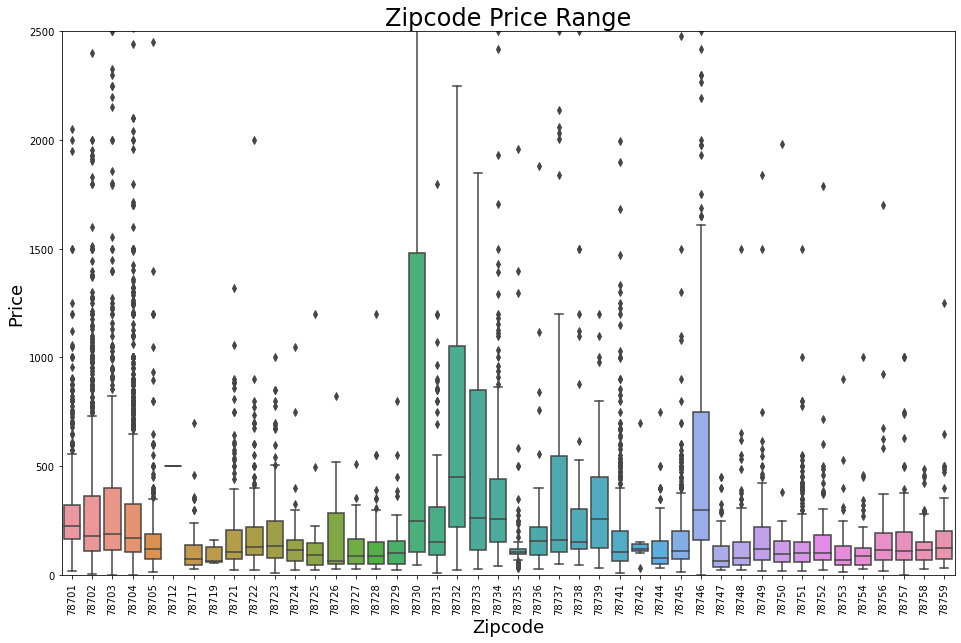

In [406]:
plt.figure(figsize =(16, 10))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=clean_to_keep)
plt.ylim((0,2500))
plt.xticks(rotation=90)
plt.title(label='Zipcode Price Range', fontsize=24)
plt.xlabel(xlabel='Zipcode', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

In [261]:
neighborhoods = pd.get_dummies(clean_to_keep['neighbourhood_cleansed'])
neighborhoods

,78701,78702,78703,78704,78705,78712,78717,78719,78721,78722,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10107,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [262]:
zipcode = pd.DataFrame()

In [263]:
zipcode['78701'] = neighborhoods[78701]
zipcode['78702'] = neighborhoods[78702]
zipcode['78703'] = neighborhoods[78703]
zipcode['78704'] = neighborhoods[78704]
zipcode['78705'] = neighborhoods[78705]
zipcode['78720'] = neighborhoods.iloc[:,5:17].sum(axis=1)
zipcode['78730'] = neighborhoods.iloc[:,17:27].sum(axis=1)
zipcode['78740'] = neighborhoods.iloc[:,27:31].sum(axis=1)
zipcode['78746'] = neighborhoods[78746]
zipcode['78750'] = neighborhoods.iloc[:,32:38].sum(axis=1)
zipcode['78759'] = neighborhoods.iloc[:,38:44].sum(axis=1)

In [264]:
zipcode

,78701,78702,78703,78704,78705,78720,78730,78740,78746,78750,78759
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10104,0,0,0,0,0,0,0,1,0,0,0
10105,0,0,0,0,0,0,0,0,1,0,0
10106,0,0,0,0,0,0,0,0,1,0,0
10107,0,0,1,0,0,0,0,0,0,0,0


In [265]:
zipcode_price = zipcode.idxmax(axis=1)
zipcode_price_df = pd.DataFrame()
zipcode_price_df['zipcode'] = zipcode_price
zipcode_price_df['price'] = clean_to_keep['price']
zipcode_price_df['zipcode'] = zipcode_price_df['zipcode'].astype(int)

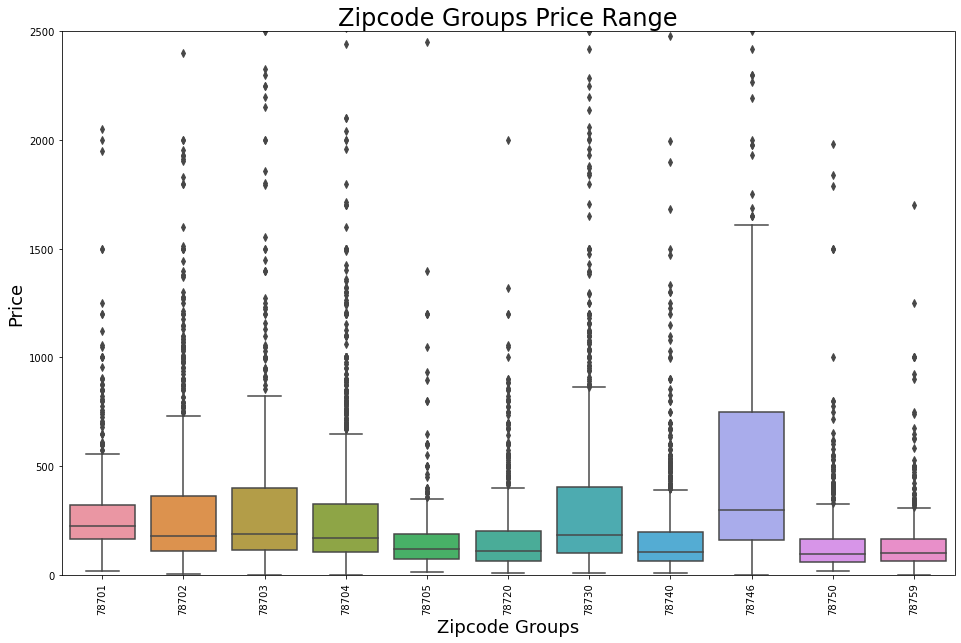

In [407]:
plt.figure(figsize =(16, 10))
sns.boxplot(x='zipcode', y='price', data=zipcode_price_df)
plt.ylim((0,2500))
plt.xticks(rotation=90)
plt.title(label='Zipcode Groups Price Range', fontsize=24)
plt.xlabel(xlabel='Zipcode Groups', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

In [267]:
clean_to_keep['amenities']

0        ["Dining table", "Cleaning before checkout", "...
1        ["Lock on bedroom door", "Heating", "Dryer", "...
2        ["Free street parking", "Air conditioning", "H...
3        ["Heating", "Cooking basics", "Washer", "TV", ...
4        ["Heating", "Shampoo", "Fire extinguisher", "I...
                               ...                        
10104    ["Heating", "Dryer", "Iron", "Washer", "TV", "...
10105    ["Cooking basics", "Dryer", "Iron", "Washer", ...
10106    ["Cooking basics", "Dryer", "Iron", "Washer", ...
10107    ["Pack \u2019n Play/travel crib", "Heating", "...
10108    ["Long term stays allowed", "Hair dryer", "Bod...
Name: amenities, Length: 10109, dtype: object

In [268]:
test_amen = clean_to_keep['amenities'].str.replace('[^\w\s]',' ').str.split('    ')
test_amen = test_amen.apply(lambda x: [item.strip() for item in x])
test_amen

/home/reza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0        [Dining table, Cleaning before checkout, Centr...
1        [Lock on bedroom door, Heating, Dryer, Iron, W...
2        [Free street parking, Air conditioning, Hanger...
3        [Heating, Cooking basics, Washer, TV, Luggage ...
4        [Heating, Shampoo, Fire extinguisher, Indoor f...
                               ...                        
10104    [Heating, Dryer, Iron, Washer, TV, Hair dryer,...
10105    [Cooking basics, Dryer, Iron, Washer, TV, Show...
10106    [Cooking basics, Dryer, Iron, Washer, TV, Show...
10107    [Pack  u2019n Play travel crib, Heating, Cooki...
10108    [Long term stays allowed, Hair dryer, Body soa...
Name: amenities, Length: 10109, dtype: object

In [617]:
amenities_dict = dict()
for ind, item in zip(test_amen.index, test_amen.values):
    for amenity in item:
        if amenity in amenities_dict.keys():
            amenities_dict[amenity] += 1
        else:
            amenities_dict[amenity] = 1
sorted_amenities = sorted(amenities_dict.items(), key=lambda x: x[1], reverse=True)  
len(sorted_amenities)

791

In [270]:
amenities = pd.DataFrame()
amenities['tv'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'tv' in x else 0)
amenities['washer_dryer'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"washer"' in x or '"dryer"' in x else 0)
amenities['long_term'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'long term' in x else 0)
amenities['refrigerator'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'refrigerator' in x else 0)
amenities['private_entrance'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'private entrance' in x else 0)
amenities['dishwasher'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"dishwasher"' in x else 0)
amenities['balcony'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'patio' in x or 'balcony' in x else 0)
amenities['yard'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'yard' in x else 0)
amenities['pool'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"pool"' in x else 0)
amenities['bbq'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'bbq' in x or 'barbeque' in x else 0)
amenities['gym'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'gym' in x else 0)
amenities['single_level'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'single level' in x else 0)
amenities['breakfast'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"breakfast"' in x else 0)
amenities['hottub'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'hot tub' in x else 0)
amenities['lake_access'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'lake access' in x else 0)

In [271]:
amenities

,tv,washer_dryer,long_term,refrigerator,private_entrance,dishwasher,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access
0,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,1,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0
10105,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0
10106,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0
10107,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0


In [272]:
all_listings = pd.concat([clean_to_keep.drop(
    columns=['price', 'neighbourhood_cleansed', 'amenities']),
                          zipcode, amenities], axis=1)
all_listings['price'] = clean_to_keep['price']

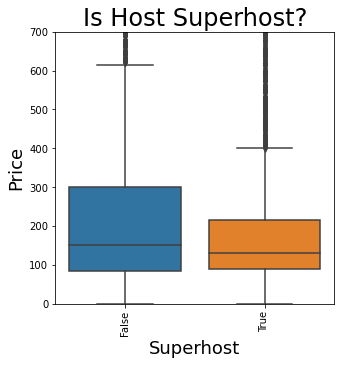

In [273]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='host_is_superhost', y='price', data=all_listings)
plt.ylim((0,700))
plt.xticks(rotation=90)
plt.title(label='Is Host Superhost?', fontsize=24)
plt.xlabel(xlabel='Superhost', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

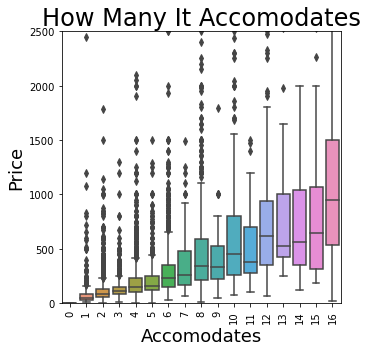

In [274]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='accommodates', y='price', data=all_listings)
plt.ylim((0,2500))
plt.xticks(rotation=90)
plt.title(label='How Many It Accomodates', fontsize=24)
plt.xlabel(xlabel='Accomodates', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

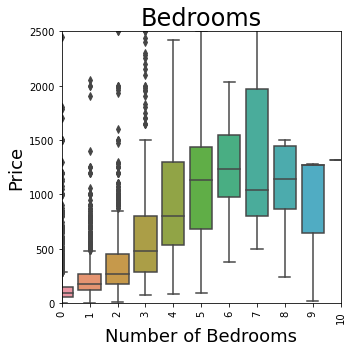

In [290]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='bedrooms', y='price', data=all_listings)
plt.xlim((0,10))
plt.ylim((0,2500))
plt.xticks(ticks=range(0, 11), labels=range(0, 11), rotation=90)
plt.title(label='Bedrooms', fontsize=24)
plt.xlabel(xlabel='Number of Bedrooms', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

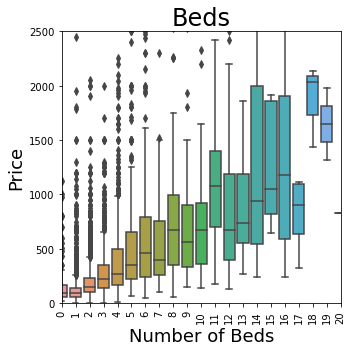

In [292]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='beds', y='price', data=all_listings)
plt.xlim((0,20))
plt.ylim((0,2500))
plt.xticks(ticks=range(0, 21), labels=range(0, 21), rotation=90)
plt.title(label='Beds', fontsize=24)
plt.xlabel(xlabel='Number of Beds', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

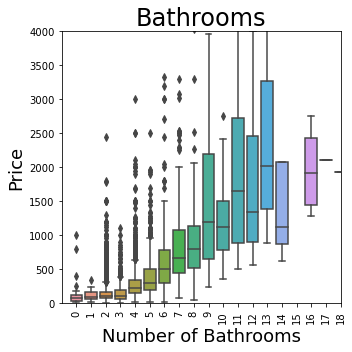

In [309]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='bathrooms', y='price', data=all_listings)
plt.xlim((-1,18))
plt.ylim((0,4000))
plt.xticks(ticks=range(0, 19), labels=range(0, 19), rotation=90)
plt.title(label='Bathrooms', fontsize=24)
plt.xlabel(xlabel='Number of Bathrooms', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

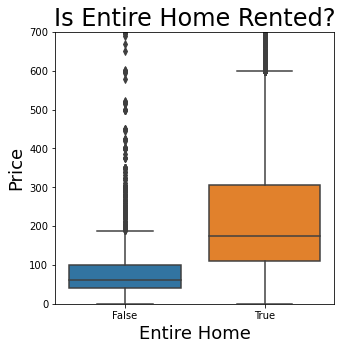

In [323]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='entire_home', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='Is Entire Home Rented?', fontsize=24)
plt.xlabel(xlabel='Entire Home', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

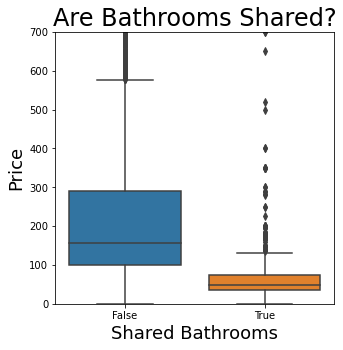

In [324]:
plt.figure(figsize =(5, 5))
sns.boxplot(x='shared_bathroom', y='price', data=all_listings)
# plt.xlim((-1,31))
plt.ylim((0,700))
# plt.xticks(ticks=range(0, 30), labels=range(0, 30), rotation=90)
plt.title(label='Are Bathrooms Shared?', fontsize=24)
plt.xlabel(xlabel='Shared Bathrooms', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

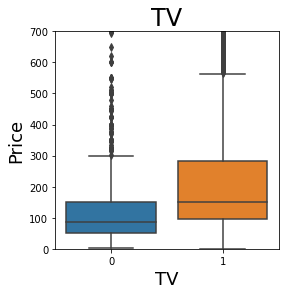

In [409]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='tv', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='TV', fontsize=24)
plt.xlabel(xlabel='TV', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

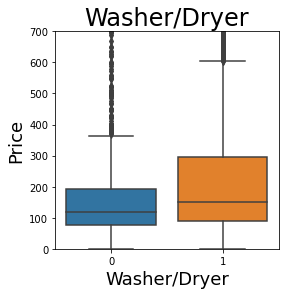

In [410]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='washer_dryer', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='Washer/Dryer', fontsize=24)
plt.xlabel(xlabel='Washer/Dryer', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

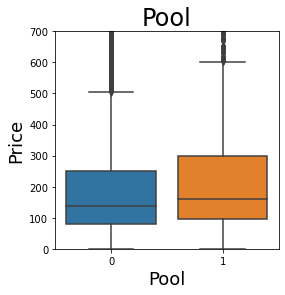

In [411]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='pool', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='Pool', fontsize=24)
plt.xlabel(xlabel='Pool', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

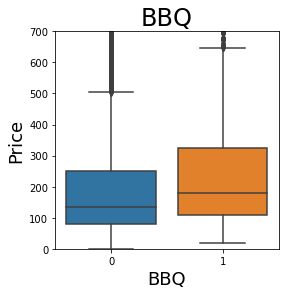

In [412]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='bbq', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='BBQ', fontsize=24)
plt.xlabel(xlabel='BBQ', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

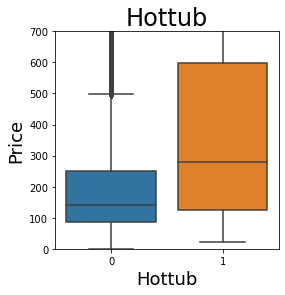

In [413]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='hottub', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='Hottub', fontsize=24)
plt.xlabel(xlabel='Hottub', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

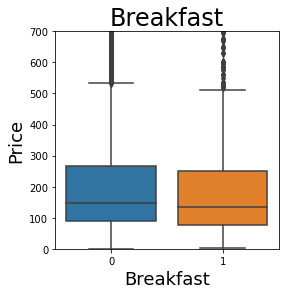

In [414]:
plt.figure(figsize =(4, 4))
sns.boxplot(x='breakfast', y='price', data=all_listings)
plt.ylim((0,700))
plt.title(label='Breakfast', fontsize=24)
plt.xlabel(xlabel='Breakfast', fontsize=18)
plt.ylabel(ylabel='Price', fontsize=18);

In [205]:
listings = all_listings[(all_listings['price'] >= 10) & (all_listings['price'] < 2500)]

In [206]:
listings = listings.dropna()
listings.describe()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_l30d,review_scores_rating,...,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access,price
count,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,...,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000
mean,4.783514,1.935069,2.598409,6.748807,617.345192,26.296746,110.158062,39.703398,0.936515,95.785249,...,0.465799,0.398265,0.259725,0.216920,0.145625,0.156182,0.114389,0.067534,0.059581,220.038612
std,3.158088,1.219351,2.340602,21.307584,522.579546,29.943446,125.343341,68.947051,1.776617,8.017086,...,0.498865,0.489576,0.438516,0.412177,0.352756,0.363054,0.318306,0.250963,0.236725,258.383634
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,0.000000,4.000000,0.000000,95.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000
50%,4.000000,2.000000,2.000000,2.000000,1124.000000,12.000000,57.000000,13.000000,0.000000,98.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,139.000000
75%,6.000000,3.000000,3.000000,3.000000,1125.000000,51.000000,214.000000,45.000000,1.000000,100.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,249.000000
max,16.000000,15.000000,39.000000,999.000000,1825.000000,90.000000,365.000000,891.000000,33.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2442.000000


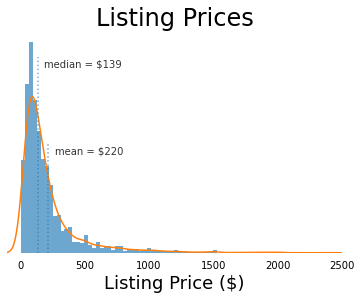

In [569]:
fig, ax = plt.subplots(figsize = (6,4))
listings['price'].plot(kind = "hist", density = True, alpha = 0.65, bins = 80) 
listings['price'].plot(kind = "kde")
price_median = listings['price'].median()
price_mean = listings['price'].mean()
quants = [[price_median, 0.6, 0.9], [price_mean, 0.6, 0.5]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
ax.set_xlabel("Listing Price ($)", fontsize=18)
ax.set_xlim(-100, 2500)
ax.set_ylim(0, 0.0055)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.text(price_median+50, 0.0047, "median = $139", size = 10, alpha = 0.8)
ax.text(price_mean+50, 0.0025, "mean = $220", size = 10, alpha = 0.8)
ax.grid(False)
ax.set_title("Listing Prices", size = 24, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [564]:
listings['price'].mean()

220.03861171366594

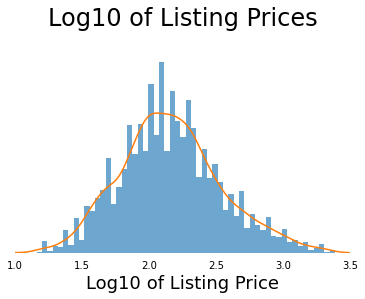

In [570]:
fig, ax = plt.subplots(figsize = (6,4))
np.log10(listings['price']).plot(kind = "hist", density = True, alpha = 0.65, bins = 60) 
np.log10(listings['price']).plot(kind = "kde")
ax.set_xlabel("Log10 of Listing Price", fontsize=18)
ax.set_xlim(1, 3.5)
ax.set_ylim(0, 1.7)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.grid(False)
ax.set_title("Log10 of Listing Prices", size = 24, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [208]:
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns='price'), 
                                                    listings['price'], 
                                                    test_size=0.2,
                                                    random_state=1)

In [209]:
X_train

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,dishwasher,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access
7753,False,True,1,1.0,1.0,29,1125,60,335,1,...,0,0,0,0,0,0,0,0,0,0
2148,False,True,1,1.0,1.0,2,28,0,104,19,...,0,0,0,0,0,0,0,0,0,0
9195,False,True,2,1.0,1.0,6,1125,16,77,4,...,0,0,0,1,0,1,0,0,0,0
3486,False,True,2,1.0,1.0,1,1125,0,0,9,...,1,0,0,0,0,0,0,1,0,0
5987,False,False,8,4.0,5.0,2,7,0,9,8,...,1,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,False,True,3,1.0,1.0,1,1125,0,0,96,...,0,0,0,0,0,0,0,0,0,0
7070,False,False,4,2.0,2.0,2,6,0,0,2,...,0,0,0,0,0,0,0,0,0,0
5469,False,True,6,3.0,3.0,2,8,0,0,12,...,0,0,0,0,0,0,0,0,0,0
277,False,True,2,1.0,1.0,1,6,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [210]:
# def cross_val_rmse(model, X_train, y_train):
#     mse_scores = cross_val_score(model, X_train, y_train, 
#                                  scoring='neg_mean_squared_error', n_jobs=-1)
#     cv_scores = cross_val_score(lr, X_train, y_train, n_jobs=-1).mean()
#     print(f'rmse cross validation: {np.mean((-1 * mse_scores)**(0.5)): 4f}')

In [211]:
def model_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    cv_mse = cross_val_score(model, X_train, y_train, 
                             scoring='neg_mean_squared_error', n_jobs=-1)
    cv_score = cross_val_score(model, X_train, y_train, n_jobs=-1).mean()
    print(f'R2 train: {model.score(X_train, y_train): 4f}')
    print(f'R2 cross val: {cv_score: 4f}')
    print(f'R2 test: {model.score(X_test, y_test): 4f}')
    print(f'rmse train: {np.sqrt(mean_squared_error(y_train, model.predict(X_train))): 4f}')
    print(f'rmse cross val: {np.mean((-1 * cv_mse)**(0.5)): 4f}')
    print(f'rmse test: {np.sqrt(mean_squared_error(y_test, model.predict(X_test))): 4f}')

In [535]:
def plot_price_predict(model, X_train, X_test, y_train, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(12,6));
    ax[0].scatter(model.predict(X_train),y_train,alpha=0.3);
    ax[0].plot([0,2000],[0,2000],color='r',ls='--');
    ax[0].set_xlabel('Predicted Price');
    ax[0].set_ylabel('Listing Price');
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
                 ax[0].get_xticklabels() + ax[0].get_yticklabels() ):
        item.set_fontsize(12)
    
    ax[1].scatter(model.predict(X_test),y_test,alpha=0.3);
    ax[1].plot([0,2000],[0,2000],color='r',ls='--');
    ax[1].set_xlabel('Predicted Price');
    ax[1].set_ylabel('Listing Price');
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
                 ax[1].get_xticklabels() + ax[1].get_yticklabels() ):
        item.set_fontsize(12)

In [213]:
lr = LinearRegression()

In [214]:
model_metrics(lr, X_train, X_test, y_train, y_test)

R2 train:  0.605269
R2 cross val:  0.597435
R2 test:  0.556796
rmse train:  163.826281
rmse cross val:  164.954452
rmse test:  165.433613


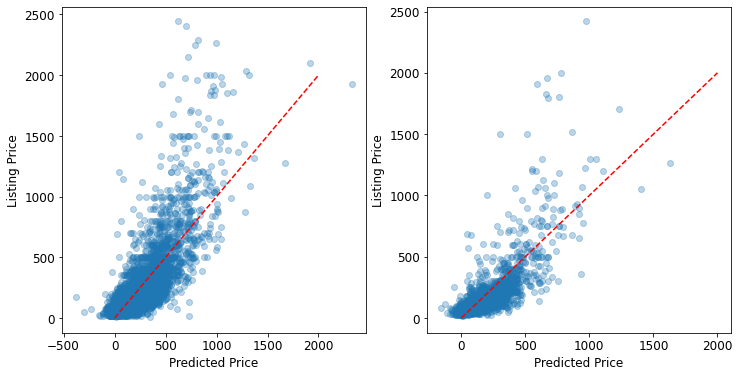

In [215]:
plot_price_predict(lr, X_train, X_test, y_train, y_test)

In [216]:
dtr = DecisionTreeRegressor(random_state=1)

In [217]:
model_metrics(dtr, X_train, X_test, y_train, y_test)

R2 train:  0.999951
R2 cross val:  0.331769
R2 test:  0.255237
rmse train:  1.825346
rmse cross val:  212.728656
rmse test:  214.452360


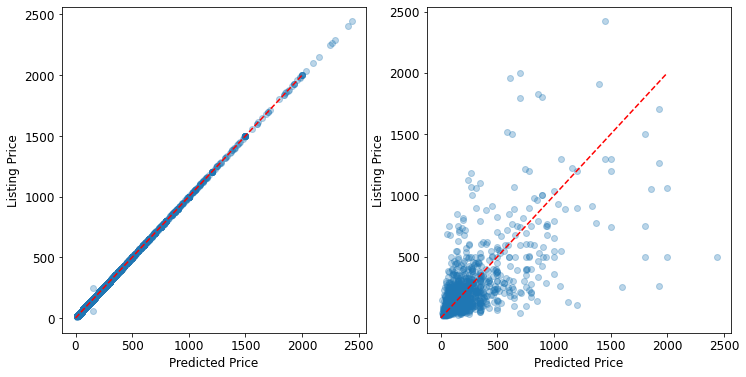

In [218]:
plot_price_predict(dtr, X_train, X_test, y_train, y_test)

In [571]:
rfr = RandomForestRegressor(n_estimators=200, max_features=10, random_state=1)

In [572]:
model_metrics(rfr, X_train, X_test, y_train, y_test)

R2 train:  0.956055
R2 cross val:  0.684877
R2 test:  0.659683
rmse train:  54.662547
rmse cross val:  146.035351
rmse test:  144.965267


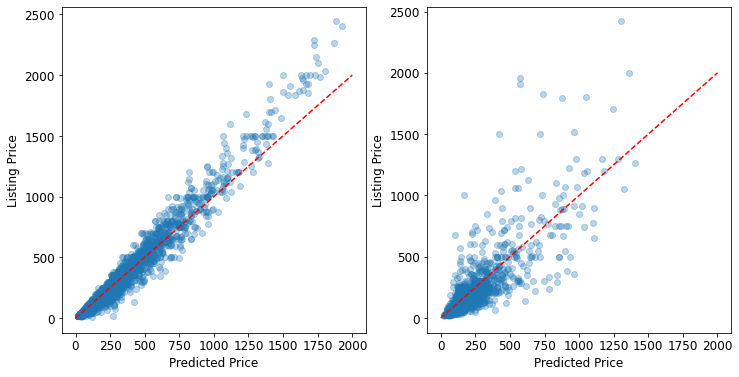

In [573]:
plot_price_predict(rfr, X_train, X_test, y_train, y_test)

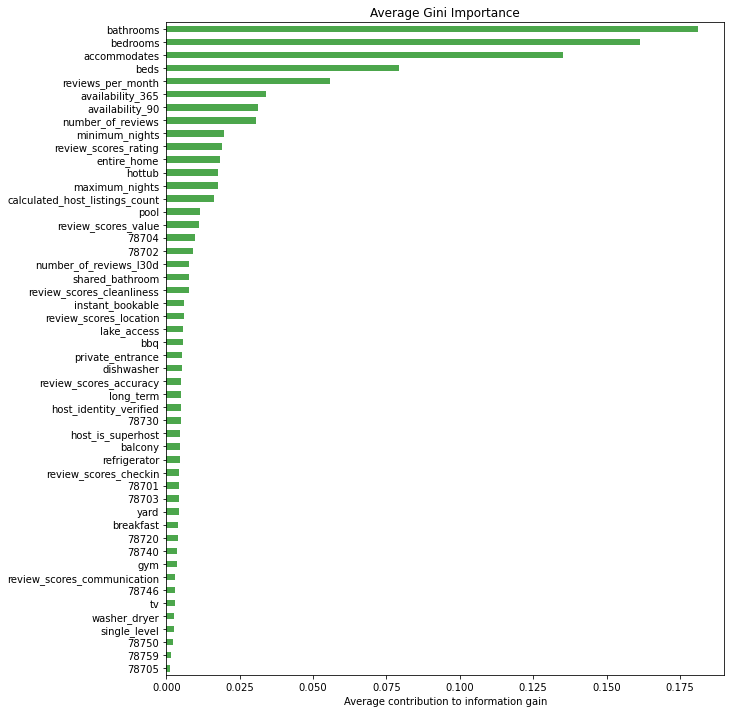

In [574]:
feature_importance_rfr = pd.Series(rfr.feature_importances_, 
                                   index=X_train.columns)
feature_importance_rfr = feature_importance_rfr.sort_values()
ax = feature_importance_rfr.plot(kind='barh', 
                                 figsize=(10,12), 
                                 color='g',alpha=0.7)
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [575]:
rfr_gs_trial_best = RandomForestRegressor(bootstrap=False, max_depth=8, 
                                          max_features='sqrt', n_estimators=200, 
                                          n_jobs=-1, random_state=1)

In [576]:
model_metrics(rfr_gs_trial_best, X_train, X_test, y_train, y_test)

R2 train:  0.797870
R2 cross val:  0.648997
R2 test:  0.634898
rmse train:  117.232516
rmse cross val:  154.063713
rmse test:  150.151261


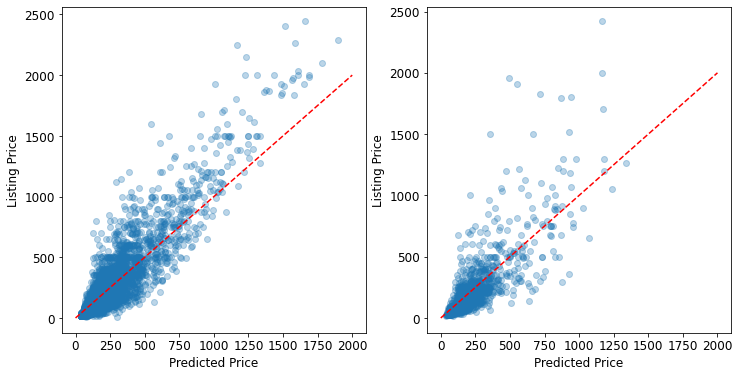

In [577]:
plot_price_predict(rfr_gs_trial_best, X_train, X_test, y_train, y_test)

In [578]:
grid_rfr = {'n_estimators': [200, 600, 1000, 1400, 1800], 
            'max_depth': [4, 8, 16, 32], 
            'min_samples_split': [2, 8, 16], 
            'max_features': [4, 16, 32],
            'max_leaf_nodes':[4 ,16 ,32]}

In [579]:
# rfr_gs = RandomForestRegressor(n_estimators=200, 
#                                max_depth=4, 
#                                min_samples_split=2, 
#                                max_features=4, 
#                                max_leaf_nodes=4, 
#                                oob_score=True, 
#                                n_jobs=-1, 
#                                random_state=1)
# rfr_gs_cv = GridSearchCV(rfr_gs, 
#                          grid_rfr, 
#                          return_train_score=True)

In [580]:
# rfr_gs_cv.fit(X_train, y_train)

In [581]:
# rfr_gs_cv.best_estimator_

In [582]:
rfr_gs_cv_best = RandomForestRegressor(max_depth=16, max_features=16, max_leaf_nodes=32, 
                                       min_samples_split=16, n_estimators=600, n_jobs=-1, 
                                       oob_score=True, random_state=1)

In [583]:
model_metrics(rfr_gs_cv_best, X_train, X_test, y_train, y_test)

R2 train:  0.714170
R2 cross val:  0.634367
R2 test:  0.614296
rmse train:  139.407738
rmse cross val:  157.192739
rmse test:  154.329397


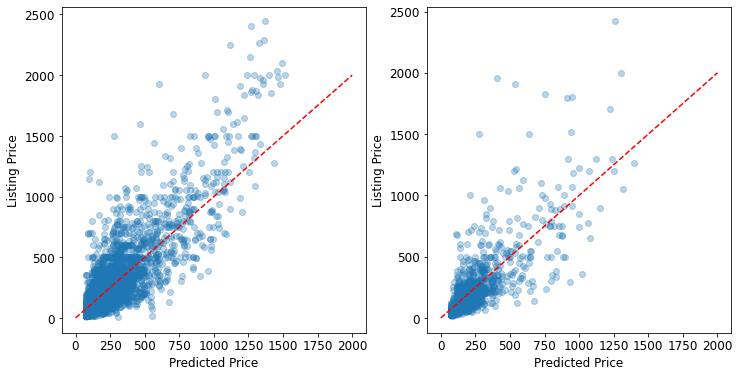

In [584]:
plot_price_predict(rfr_gs_cv_best, X_train, X_test, y_train, y_test)

In [438]:
grid_rfr_2 = {'max_depth': [1, 2, 3, 4, 5, 6, 8, 10]}

In [439]:
# rfr_gs_2 = RandomForestRegressor(max_depth=10, max_features=16, max_leaf_nodes=32, 
#                                  min_samples_split=16, n_estimators=600, n_jobs=-1, 
#                                  oob_score=True, random_state=1)
# rfr_gs_cv_2 = GridSearchCV(rfr_gs_2, 
#                            grid_rfr_2, 
#                            return_train_score=True)

In [440]:
# rfr_gs_cv_2.fit(X_train_new, y_train_new)

In [441]:
# rfr_gs_cv_2.best_estimator_

In [461]:
# rfr_gs_cv_2_best = RandomForestRegressor(max_depth=10, max_features=16, max_leaf_nodes=32, 
#                                          min_samples_split=16, n_estimators=600, n_jobs=-1, 
#                                          oob_score=True, random_state=1)

In [462]:
# model_metrics(rfr_gs_cv_2_best, X_train_new, X_test_new, y_train_new, y_test_new)

In [463]:
# plot_price_predict(rfr_gs_cv_2_best, X_train_new, X_test_new, y_train_new, y_test_new)

In [445]:
gbr = GradientBoostingRegressor(n_estimators=1000)

In [446]:
model_metrics(gbr, X_train, X_test, y_train, y_test)

R2 train:  0.919399
R2 cross val:  0.678035
R2 test:  0.635076
rmse train:  74.029029
rmse cross val:  147.939433
rmse test:  150.114679


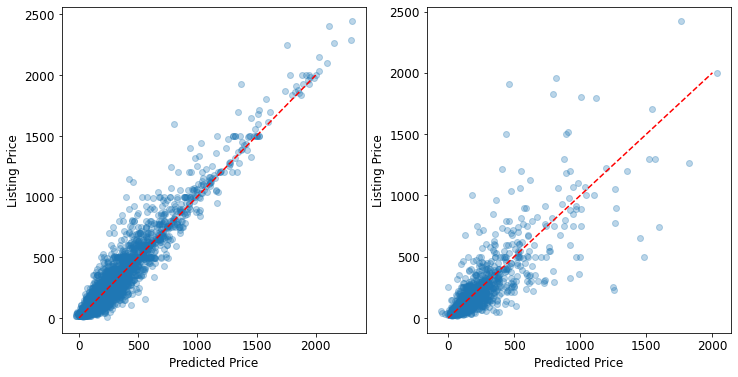

In [448]:
plot_price_predict(gbr, X_train, X_test, y_train, y_test)

In [ ]:
grid_gbr = {'learning_rate': [0.01, 0.02, 0.05, 0.1], 
            'max_depth':[2, 4, 8, 12, 16, 24], 
            'min_samples_split':[2, 4, 6, 8, 10], 
            'max_features': [0.1, 0.3, 1.0], 
            'n_estimators': [1000, 2000]}

In [ ]:
# gbr_gs = GradientBoostingRegressor(n_estimators=2000, 
#                                    learning_rate=0.1, 
#                                    max_depth=4, 
#                                    min_samples_split=2, 
#                                    max_features=0.1, 
#                                    random_state=1)
# gbr_gs_cv = GridSearchCV(gbr_gs, 
#                          grid_gbr, 
#                          return_train_score=True)

In [ ]:
# gbr_gs_cv.fit(X_train, y_train)

In [ ]:
# gbr_gs_cv.best_estimator_

In [449]:
gbr_gs_cv_best = GradientBoostingRegressor(learning_rate=0.02, max_depth=8, 
                                           max_features=0.1, min_samples_split=10, 
                                           n_estimators=1000, random_state=1)

In [450]:
model_metrics(gbr_gs_cv_best, X_train, X_test, y_train, y_test)

R2 train:  0.977428
R2 cross val:  0.712671
R2 test:  0.695266
rmse train:  39.176231
rmse cross val:  139.441464
rmse test:  137.177215


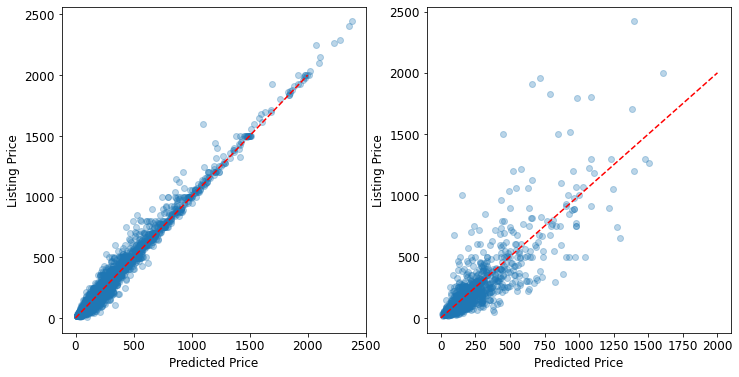

In [451]:
plot_price_predict(gbr_gs_cv_best, X_train, X_test, y_train, y_test)

In [452]:
xgbr = XGBRegressor(random_state=1)
xgbr

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=1, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [453]:
model_metrics(xgbr, X_train, X_test, y_train, y_test)

R2 train:  0.976201
R2 cross val:  0.665400
R2 test:  0.668623
rmse train:  40.226903
rmse cross val:  150.363624
rmse test:  143.048479


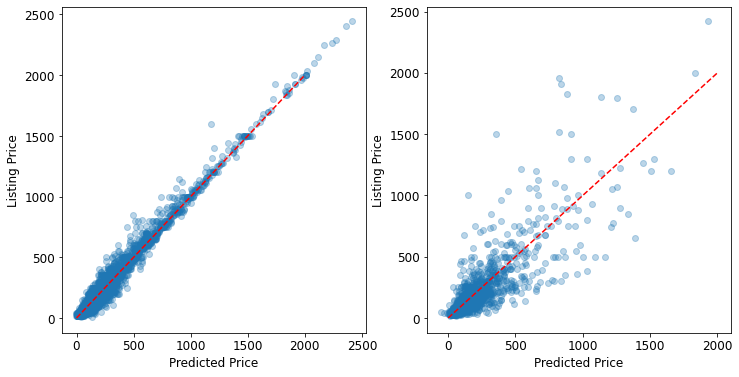

In [454]:
plot_price_predict(xgbr, X_train, X_test, y_train, y_test)

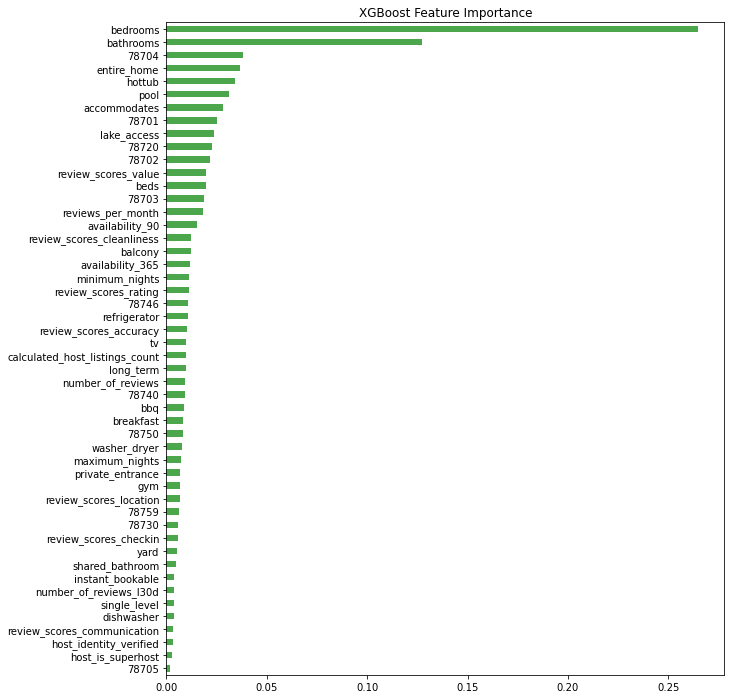

In [585]:
feature_importance_xgbr = pd.Series(xgbr.feature_importances_, 
                                    index=X_train.columns)
feature_importance_xgbr = feature_importance_xgbr.sort_values()
ax = feature_importance_xgbr.plot(kind='barh', 
                                  figsize=(10,12), 
                                  color='g',alpha=0.7)
ax.set_title('XGBoost Feature Importance');

In [458]:
xgbr_01 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                       importance_type='gain', interaction_constraints='',
                       learning_rate=0.3, max_delta_step=0, max_depth=5,
                       min_child_weight=1, monotone_constraints='()',
                       n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
                       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, subsample=1,
                       tree_method='exact', validate_parameters=1, verbosity=None)

In [459]:
model_metrics(xgbr_01, X_train, X_test, y_train, y_test)

R2 train:  0.949306
R2 cross val:  0.671442
R2 test:  0.674513
rmse train:  58.709860
rmse cross val:  149.019754
rmse test:  141.771496


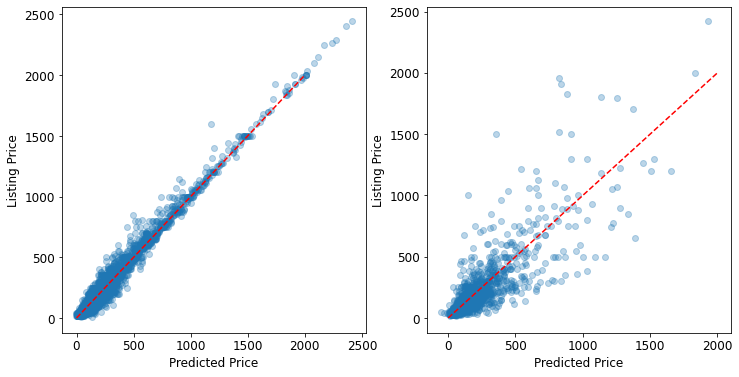

In [460]:
plot_price_predict(xgbr, X_train, X_test, y_train, y_test)

In [464]:
listings_new = listings[~((listings['number_of_reviews_l30d']<2) & 
                          (listings['availability_90']<40) & 
                          (listings['price']>200))]

In [465]:
listings_new

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access,price
0,False,True,4,2.0,2.0,7,180,60,150,25,...,1,1,0,0,0,1,1,0,0,200.0
1,False,True,2,1.0,2.0,30,60,0,0,9,...,0,0,0,0,0,0,1,0,0,114.0
2,True,True,3,1.0,2.0,2,90,65,326,548,...,1,1,0,0,0,0,0,0,0,104.0
3,False,False,1,1.0,3.0,30,60,31,31,22,...,1,1,0,1,0,0,0,0,0,46.0
4,True,True,2,1.0,1.0,1,14,7,7,262,...,0,0,0,0,0,0,0,0,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10026,False,True,6,3.0,3.0,1,1125,21,39,2,...,1,1,0,1,0,0,0,0,0,316.0
10029,False,False,4,1.0,2.0,1,1125,68,343,1,...,0,0,0,1,0,0,0,0,0,123.0
10033,False,True,4,2.0,2.0,3,10,21,35,1,...,1,0,0,0,0,0,0,0,0,159.0
10089,False,True,6,2.0,2.0,1,365,83,358,1,...,0,0,1,1,1,0,0,0,0,224.0


In [466]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    listings_new.drop(columns='price'), 
    listings_new['price'], 
    test_size=0.2, 
    random_state=1)

In [587]:
xgbr_new = XGBRegressor(max_depth=5, random_state=1)
xgbr_new

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=1, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [588]:
model_metrics(xgbr_new, X_train_new, X_test_new, y_train_new, y_test_new)

R2 train:  0.974417
R2 cross val:  0.703425
R2 test:  0.731900
rmse train:  33.048960
rmse cross val:  112.062183
rmse test:  131.157422


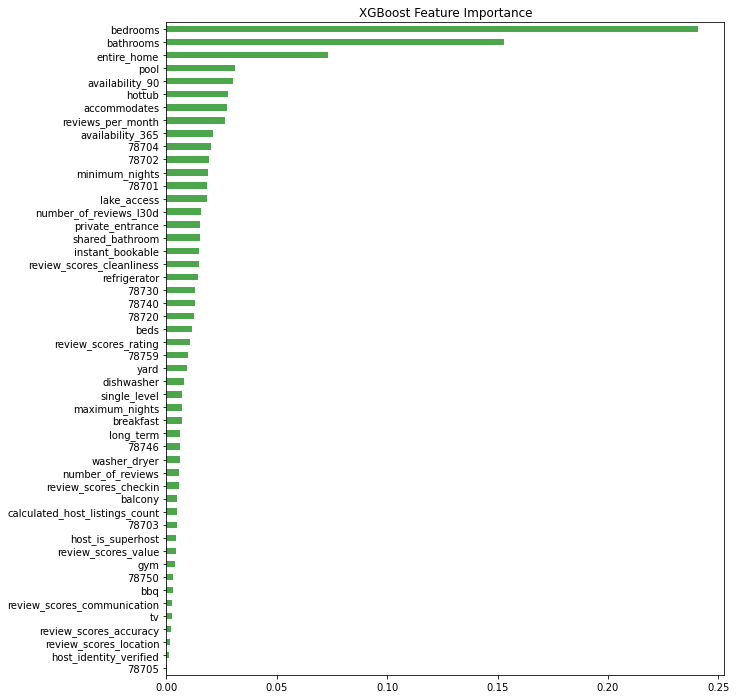

In [590]:
feature_importance_xgbr_new = pd.Series(xgbr_new.feature_importances_, 
                                        index=X_train.columns)
feature_importance_xgbr_new = feature_importance_xgbr_new.sort_values()
ax = feature_importance_xgbr_new.plot(kind='barh', 
                                      figsize=(10,12), 
                                      color='g',alpha=0.7)
ax.set_title('XGBoost Feature Importance');

In [470]:
xgbr_new_imp_feat = list(feature_importance_xgbr_new[5:].index)

In [471]:
model_metrics(xgbr_new, X_train_new.loc[:, xgbr_new_imp_feat], 
              X_test_new.loc[:, xgbr_new_imp_feat], 
              y_train_new, y_test_new)

R2 train:  0.975162
R2 cross val:  0.693605
R2 test:  0.750073
rmse train:  32.564189
rmse cross val:  113.868978
rmse test:  126.634215


In [472]:
xgbr_new.fit(X_train_new, y_train_new)
permut_imp_xgbr_new = permutation_importance(xgbr_new, X_train_new, 
                                             y_train_new, n_jobs=-1, n_repeats=10)

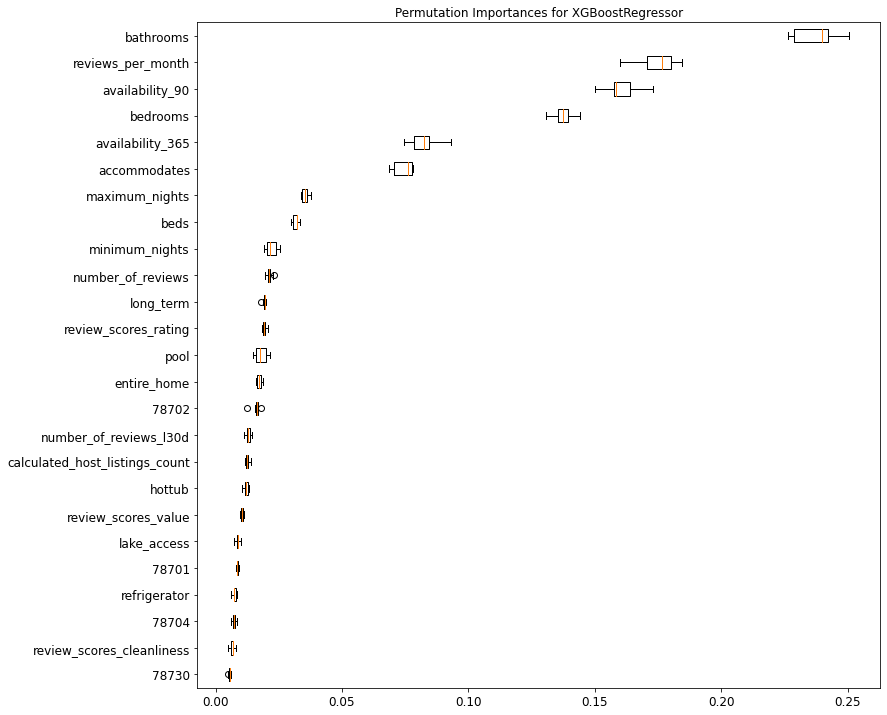

In [473]:
permut_imp_sorted_idx = permut_imp_xgbr_new.importances_mean.argsort()[-25:]
fig, ax = plt.subplots(figsize=(12,10))
ax.boxplot(permut_imp_xgbr_new.importances[permut_imp_sorted_idx].T,
           vert=False, labels=X_train.columns[permut_imp_sorted_idx])
ax.set_title("Permutation Importances for XGBoostRegressor")
fig.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(12)

In [474]:
model_metrics(xgbr_new, X_train_new.loc[:, X_train.columns[permut_imp_sorted_idx]], 
              X_test_new.loc[:, X_train.columns[permut_imp_sorted_idx]], 
              y_train_new, y_test_new)

R2 train:  0.971561
R2 cross val:  0.676525
R2 test:  0.732005
rmse train:  34.844456
rmse cross val:  116.844808
rmse test:  131.131895


In [475]:
xgbr_02 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                       importance_type='gain', interaction_constraints='',
                       learning_rate=0.3, max_delta_step=0, max_depth=5,
                       min_child_weight=1, monotone_constraints='()',
                       n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
                       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, subsample=1,
                       tree_method='exact', validate_parameters=1, verbosity=None)

In [476]:
model_metrics(xgbr_02, X_train_new, X_test_new, y_train_new, y_test_new)

R2 train:  0.974416
R2 cross val:  0.703977
R2 test:  0.731900
rmse train:  33.049121
rmse cross val:  111.951106
rmse test:  131.157446


In [477]:
grid_xgbr = {'max_depth': [4, 5, 6], 
             'gamma': [0, 0.2], 
             'subsample': [0.6, 1], 
             'colsample_bytree': [0.6, 1], 
             'max_depth': [3, 5, 7], 
             'min_child_weight': [1, 5] , 
             'gamma': [0, 0.3], 
             'reg_alpha':[1e-5, 1e-2, 100]}

In [478]:
# xgbr_gs_cv = GridSearchCV(xgbr_02, 
#                           grid_xgbr, 
#                           return_train_score=True)

In [479]:
# xgbr_gs_cv.fit(X_train_new, y_train_new)

In [480]:
# xgbr_gs_cv.best_estimator_

In [531]:
xgbr_gs_cv_best = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
                               colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, 
                               gpu_id=-1, importance_type='gain', 
                               interaction_constraints='', 
                               learning_rate=0.3, max_delta_step=0, max_depth=5, 
                               min_child_weight=5, monotone_constraints='()', 
                               n_estimators=100, n_jobs=4, num_parallel_tree=1, 
                               random_state=1, reg_alpha=100, reg_lambda=1, 
                               scale_pos_weight=1, subsample=1, tree_method='exact', 
                               validate_parameters=1, verbosity=None)

In [532]:
model_metrics(xgbr_gs_cv_best, X_train_new, X_test_new, y_train_new, y_test_new)

R2 train:  0.964980
R2 cross val:  0.713961
R2 test:  0.761658
rmse train:  38.666634
rmse cross val:  110.049324
rmse test:  123.664458


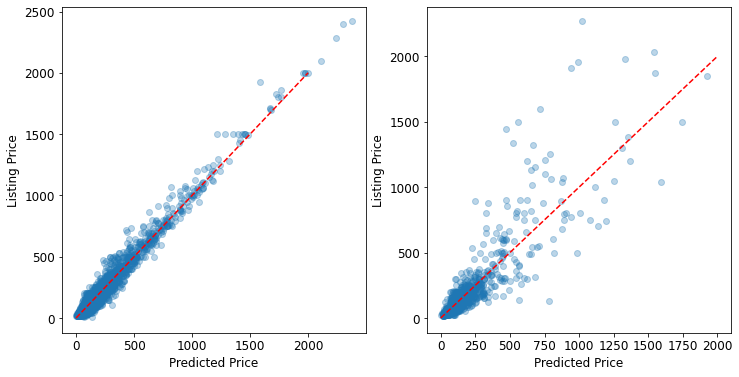

In [533]:
plot_price_predict(xgbr_gs_cv_best, X_train_new, X_test_new, y_train_new, y_test_new)

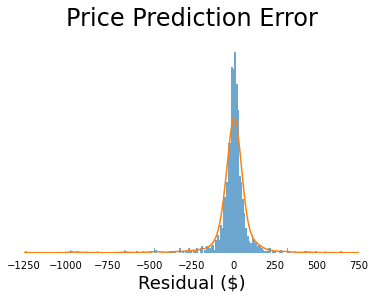

In [534]:
fig, ax = plt.subplots(figsize = (6,4))
(xgbr_gs_cv_best.predict(X_test_new) - y_test_new).plot(kind = "hist", density = True, alpha = 0.65, bins = 200) 
(xgbr_gs_cv_best.predict(X_test_new) - y_test_new).plot(kind = "kde")
ax.set_xlabel("Residual ($)", fontsize=18)
ax.set_xlim(-1250, 750)
ax.set_ylim(0, 0.012)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.grid(False)
ax.set_title("Price Prediction Error", size = 24, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [485]:
raw_data.iloc[5118, :]

id                                                                                       27524298
listing_url                                                 https://www.airbnb.com/rooms/27524298
scrape_id                                                                          20210416175518
last_scraped                                                                           2021-04-19
name                                            Beat the Texas Heat in a Private Pool in Charm...
                                                                      ...                        
calculated_host_listings_count                                                                  1
calculated_host_listings_count_entire_homes                                                     1
calculated_host_listings_count_private_rooms                                                    0
calculated_host_listings_count_shared_rooms                                                     0
reviews_per_month   

In [507]:
listings_800 = listings_new[listings_new['price'] <= 800]
listings_800.shape

(5685, 51)

In [508]:
X_train_800, X_test_800, y_train_800, y_test_800 = train_test_split(
    listings_800.drop(columns='price'), 
    listings_800['price'], 
    test_size=0.2, 
    random_state=1)

In [509]:
model_metrics(xgbr_gs_cv_best, X_train_800, X_test_800, y_train_800, y_test_800)

R2 train:  0.932058
R2 cross val:  0.703288
R2 test:  0.756065
rmse train:  33.142005
rmse cross val:  69.007183
rmse test:  62.437758


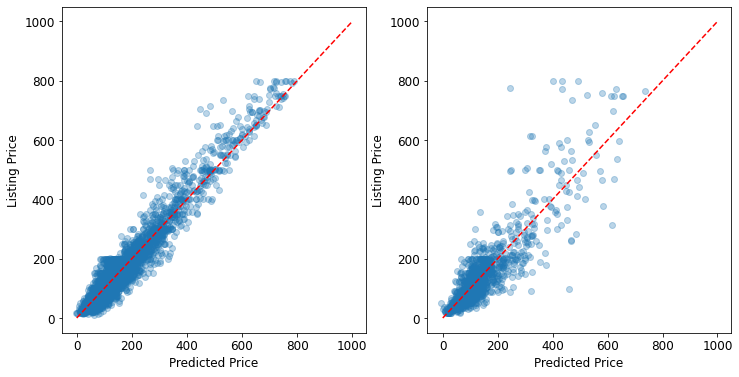

In [529]:
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].scatter(xgbr_gs_cv_best.predict(X_train_800),y_train_800,alpha=0.3);
ax[0].plot([0,1000],[0,1000],color='r',ls='--');
ax[0].set_xlabel('Predicted Price');
ax[0].set_ylabel('Listing Price');
for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels() ):
    item.set_fontsize(12)

ax[1].scatter(xgbr_gs_cv_best.predict(X_test_800),y_test_800,alpha=0.3);
ax[1].plot([0,1000],[0,1000],color='r',ls='--');
ax[1].set_xlabel('Predicted Price');
ax[1].set_ylabel('Listing Price');
for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels() ):
    item.set_fontsize(12)

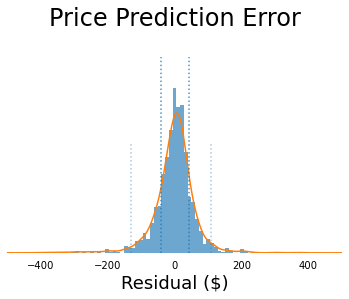

In [526]:
fig, ax = plt.subplots(figsize = (6,4))
resid_800 = (xgbr_gs_cv_best.predict(X_test_800) - y_test_800)
resid_800.plot(kind = "hist", density = True, alpha = 0.65, bins = 80) 
resid_800.plot(kind = "kde")
quant_16, quant_84 = resid_800.quantile(0.16), resid_800.quantile(0.84)
quant_025, quant_975 = resid_800.quantile(0.025), resid_800.quantile(0.975)
quants = [[quant_16, 0.8, 0.9], [quant_84, 0.8, 0.9], 
          [quant_025, 0.4, 0.5], [quant_975, 0.4, 0.5]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
ax.set_xlabel("Residual ($)", fontsize=18)
ax.set_xlim(-500, 500)
ax.set_ylim(0, 0.015)
ax.set_yticklabels([])
ax.set_ylabel("")
ax.grid(False)
ax.set_title("Price Prediction Error", size = 24, pad = 10)
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [523]:
resid_800.quantile(0.975)

108.2688812255859

In [536]:
listings_review_drop = listings_800.drop(columns=['review_scores_rating', 
                                                  'review_scores_accuracy', 
                                                  'review_scores_cleanliness', 
                                                  'review_scores_checkin', 
                                                  'review_scores_communication', 
                                                  'review_scores_location', 
                                                  'review_scores_value'])

In [541]:
X_train_rev_drop, X_test_rev_drop, y_train_rev_drop, y_test_rev_drop = train_test_split(
    listings_review_drop.drop(columns='price'), 
    listings_review_drop['price'], 
    test_size=0.2, 
    random_state=1)

In [542]:
model_metrics(xgbr_gs_cv_best, X_train_rev_drop, X_test_rev_drop, y_train_rev_drop, y_test_rev_drop)

R2 train:  0.926905
R2 cross val:  0.705294
R2 test:  0.748197
rmse train:  34.375676
rmse cross val:  68.662254
rmse test:  63.436737


In [591]:
all_listings[all_listings['price'] > 5000]

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access,price
325,False,False,4,1.0,2.0,3,14,0,0,2,...,0,0,1,0,1,0,0,0,0,5021.0
960,False,True,10,4.0,4.0,30,900,0,0,3,...,0,0,0,0,0,0,0,0,0,10000.0
3214,False,True,2,1.0,1.0,1,1125,89,364,2,...,0,0,1,0,0,0,0,0,0,10000.0
3481,False,True,8,3.0,4.0,2,365,90,365,2,...,0,0,0,0,0,0,0,0,0,5550.0
3498,False,True,16,8.0,10.0,3,365,43,286,0,...,0,0,1,0,0,0,0,0,0,9435.0
4330,False,True,5,1.0,3.0,500,1125,90,180,1,...,0,0,1,0,1,0,0,0,0,10000.0
5084,False,False,6,2.0,3.0,1,365,0,0,49,...,0,0,1,1,0,0,0,0,0,9999.0
6255,False,True,10,3.0,4.0,1,365,0,17,0,...,1,0,1,0,1,0,0,0,0,5499.0
6652,False,True,16,5.0,8.0,1,365,32,284,0,...,0,0,1,1,0,0,0,1,0,5499.0
6653,False,True,12,6.0,6.0,1,365,0,275,0,...,0,0,1,1,0,0,0,1,0,13199.0


In [614]:
raw_data.loc[9745, :]

id                                                                           48714735
listing_url                                     https://www.airbnb.com/rooms/48714735
scrape_id                                                              20210416175518
last_scraped                                                               2021-04-18
name                                             Pinnacle Peak - Pool and Lake Views!
                                                                ...                  
calculated_host_listings_count                                                     60
calculated_host_listings_count_entire_homes                                        60
calculated_host_listings_count_private_rooms                                        0
calculated_host_listings_count_shared_rooms                                         0
reviews_per_month                                                                 NaN
Name: 9745, Length: 74, dtype: object